In [56]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from IPython.display import Image

I0000 00:00:1754117857.875153 1936192 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754117857.937104 2073220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754117857.952149 2073221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


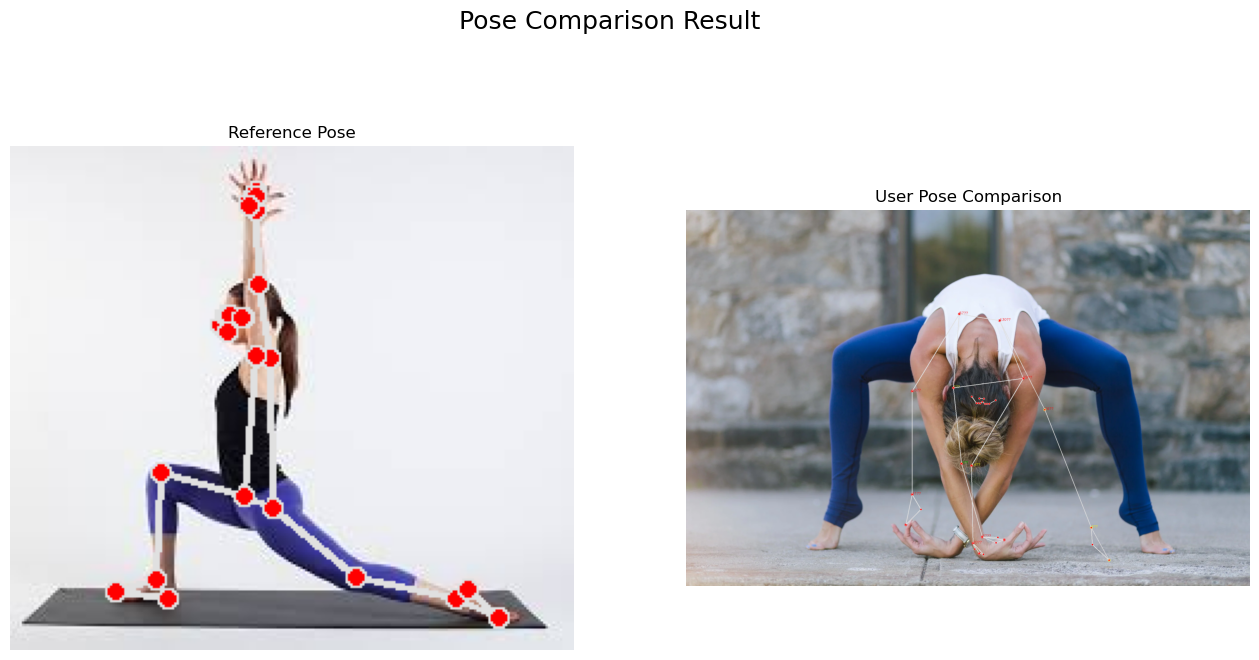

📝 Feedback:

⚠️ Left Elbow: Slight difference (14°). Adjust slightly.
✅ Right Elbow: Well aligned.
❌ Left Shoulder: Off by 29°. Adjust your left shoulder.
⚠️ Right Shoulder: Slight difference (6°). Adjust slightly.
❌ Left Hip: Off by 130°. Adjust your left hip.
❌ Right Hip: Off by 57°. Adjust your right hip.
❌ Left Knee: Off by 26°. Adjust your left knee.
❌ Right Knee: Off by 83°. Adjust your right knee.
⚠️ Left Ankle: Slight difference (9°). Adjust slightly.
❌ Right Ankle: Off by 61°. Adjust your right ankle.
❌ Left Wrist: Off by 20°. Adjust your left wrist.
❌ Right Wrist: Off by 67°. Adjust your right wrist.


In [58]:
# --- Setup Pose Estimator ---
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

# --- Utility: Extract (x, y) pose landmarks from an image ---
def extract_landmarks(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb)
    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        coords = [(lm.x, lm.y) for lm in landmarks]
        return coords, result.pose_landmarks
    return None, None

# --- Utility: Calculate joint angle between 3 points ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

# --- Define joint triplets for angle comparison ---
angle_joints = {
    'left_elbow':     [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    'right_elbow':    [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    'left_shoulder':  [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP],
    'right_shoulder': [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP],
    'left_hip':       [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE],
    'right_hip':      [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE],
    'left_knee':      [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    'right_knee':     [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    'left_ankle':     [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_FOOT_INDEX],
    'right_ankle':    [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX],
    'left_wrist':     [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST, mp_pose.PoseLandmark.LEFT_INDEX],
    'right_wrist':    [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST, mp_pose.PoseLandmark.RIGHT_INDEX],
}

# --- Flip input pose if facing opposite direction from reference ---
def maybe_flip_landmarks(ref_landmarks, input_landmarks):
    def is_facing_left(landmarks):
        return landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value][0] > landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value][0]
    
    if is_facing_left(ref_landmarks) != is_facing_left(input_landmarks):
        flipped = input_landmarks.copy()
        mirror_map = {
            mp_pose.PoseLandmark.LEFT_SHOULDER.value: mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
            mp_pose.PoseLandmark.RIGHT_SHOULDER.value: mp_pose.PoseLandmark.LEFT_SHOULDER.value,
            mp_pose.PoseLandmark.LEFT_ELBOW.value: mp_pose.PoseLandmark.RIGHT_ELBOW.value,
            mp_pose.PoseLandmark.RIGHT_ELBOW.value: mp_pose.PoseLandmark.LEFT_ELBOW.value,
            mp_pose.PoseLandmark.LEFT_WRIST.value: mp_pose.PoseLandmark.RIGHT_WRIST.value,
            mp_pose.PoseLandmark.RIGHT_WRIST.value: mp_pose.PoseLandmark.LEFT_WRIST.value,
            mp_pose.PoseLandmark.LEFT_HIP.value: mp_pose.PoseLandmark.RIGHT_HIP.value,
            mp_pose.PoseLandmark.RIGHT_HIP.value: mp_pose.PoseLandmark.LEFT_HIP.value,
            mp_pose.PoseLandmark.LEFT_KNEE.value: mp_pose.PoseLandmark.RIGHT_KNEE.value,
            mp_pose.PoseLandmark.RIGHT_KNEE.value: mp_pose.PoseLandmark.LEFT_KNEE.value,
            mp_pose.PoseLandmark.LEFT_ANKLE.value: mp_pose.PoseLandmark.RIGHT_ANKLE.value,
            mp_pose.PoseLandmark.RIGHT_ANKLE.value: mp_pose.PoseLandmark.LEFT_ANKLE.value,
            mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value: mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value: mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.LEFT_INDEX.value: mp_pose.PoseLandmark.RIGHT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_INDEX.value: mp_pose.PoseLandmark.LEFT_INDEX.value,
        }
        for k, v in mirror_map.items():
            flipped[k], flipped[v] = flipped[v], flipped[k]
        return flipped
    return input_landmarks

# --- Compare angles between poses ---
def compare_angles(ref, inp):
    diffs = {}
    for joint, (p1, p2, p3) in angle_joints.items():
        a1 = calculate_angle(ref[p1.value], ref[p2.value], ref[p3.value])
        a2 = calculate_angle(inp[p1.value], inp[p2.value], inp[p3.value])
        diffs[joint] = {
            'ref_angle': round(a1, 2),
            'input_angle': round(a2, 2),
            'difference': round(abs(a1 - a2), 2)
        }
    return diffs

# --- Visual feedback on user image ---
def draw_pose_feedback(image, landmarks, differences):
    h, w = image.shape[:2]
    annotated = image.copy()

    for joint, (p1, p2, p3) in angle_joints.items():
        diff = differences[joint]['difference']
        color = (0, 255, 0) if diff < 5 else (0, 255, 255) if diff < 15 else (0, 0, 255)

        pts = [landmarks[p.value] for p in [p1, p2, p3]]
        pts = [(int(x * w), int(y * h)) for x, y in pts]

        for pt in pts:
            cv2.circle(annotated, pt, 6, color, -1)
        cv2.line(annotated, pts[0], pts[1], color, 2)
        cv2.line(annotated, pts[1], pts[2], color, 2)
        cv2.putText(annotated, f"{int(diff)}°", pts[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return annotated

# --- Text feedback generator ---
def generate_feedback(angle_diffs):
    feedback = []
    for joint, data in angle_diffs.items():
        j = joint.replace('_', ' ').title()
        d = data['difference']
        if d < 5:
            feedback.append(f"✅ {j}: Well aligned.")
        elif d < 15:
            feedback.append(f"⚠️ {j}: Slight difference ({int(d)}°). Adjust slightly.")
        else:
            feedback.append(f"❌ {j}: Off by {int(d)}°. Adjust your {j.lower()}.")
    return "\n".join(feedback)

# --- Load and process images ---
ref_img = cv2.imread("arrow_lunge.jpeg")
input_img = cv2.imread("cross.webp")

ref_landmarks, ref_pose = extract_landmarks(ref_img)
input_landmarks, input_pose = extract_landmarks(input_img)

if ref_landmarks and input_landmarks:
    # Normalize direction
    input_landmarks = maybe_flip_landmarks(ref_landmarks, input_landmarks)

    # Compare poses
    angle_diffs = compare_angles(ref_landmarks, input_landmarks)
    feedback_text = generate_feedback(angle_diffs)

    # Annotate input and reference
    annotated_input = draw_pose_feedback(input_img, input_landmarks, angle_diffs)
    annotated_ref = ref_img.copy()
    mp_drawing.draw_landmarks(annotated_ref, ref_pose, mp_pose.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(annotated_input, input_pose, mp_pose.POSE_CONNECTIONS)

    # Display results
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(annotated_ref, cv2.COLOR_BGR2RGB))
    plt.title("Reference Pose")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(annotated_input, cv2.COLOR_BGR2RGB))
    plt.title("User Pose Comparison")
    plt.axis('off')

    plt.suptitle("Pose Comparison Result", fontsize=18)
    plt.show()

    # Save result
    output_path = "/mnt/data/pose_feedback_result.jpg"
    cv2.imwrite(output_path, annotated_input)

    # Print feedback
    print("📝 Feedback:\n")
    print(feedback_text)

else:
    print("❌ Pose detection failed on one or both images.")


I0000 00:00:1754117858.357212 1936192 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754117858.413359 2073267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754117858.424433 2073269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


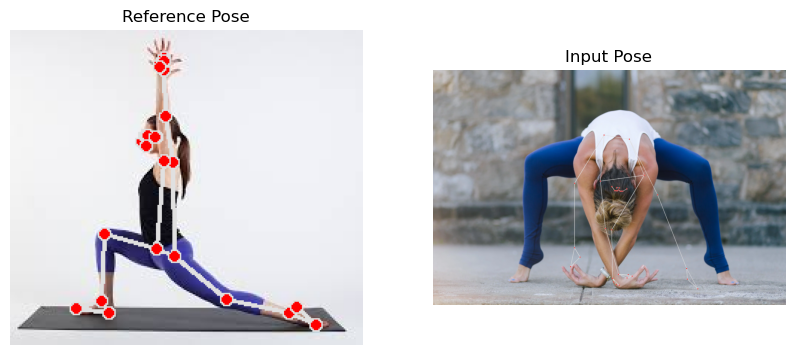


Pose similarity score: 2.2792
🔴 Poor match. Pose differs significantly.


In [60]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(image):
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks:
        return None, None
    landmarks = results.pose_landmarks.landmark
    coords = np.array([(lm.x, lm.y) for lm in landmarks])
    return coords, results.pose_landmarks

def normalize_landmarks(landmarks):
    center = np.mean(landmarks, axis=0)
    centered = landmarks - center
    scale = np.linalg.norm(np.max(centered, axis=0) - np.min(centered, axis=0))
    return centered / scale

def compute_pose_similarity(ref_landmarks, input_landmarks):
    if ref_landmarks is None or input_landmarks is None:
        return None

    ref_norm = normalize_landmarks(ref_landmarks)
    input_norm = normalize_landmarks(input_landmarks)
    
    # If mirrored, try flipped version
    input_flipped = input_norm.copy()
    input_flipped[:, 0] *= -1
    d1 = np.linalg.norm(ref_norm - input_norm)
    d2 = np.linalg.norm(ref_norm - input_flipped)
    best = min(d1, d2)

    return best

def annotate_and_show(image, landmarks, title):
    annotated = image.copy()
    if landmarks:
        mp_drawing.draw_landmarks(
            annotated, landmarks, mp_pose.POSE_CONNECTIONS)
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.imshow(annotated_rgb)
    plt.title(title)
    plt.axis('off')

def compare_poses(ref_path, input_path, export_csv=True):
    ref_image = cv2.imread(ref_path)
    input_image = cv2.imread(input_path)

    ref_coords, ref_landmarks = extract_landmarks(ref_image)
    input_coords, input_landmarks = extract_landmarks(input_image)

    score = compute_pose_similarity(ref_coords, input_coords)

    # Display annotated images side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    annotate_and_show(ref_image, ref_landmarks, "Reference Pose")
    plt.subplot(1, 2, 2)
    annotate_and_show(input_image, input_landmarks, "Input Pose")
    plt.show()

    # Score feedback
    if score is not None:
        print(f"\nPose similarity score: {score:.4f}")
        if score < 0.05:
            print("✅ Excellent match!")
        elif score < 0.10:
            print("🟡 Moderate match. Try adjusting posture slightly.")
        else:
            print("🔴 Poor match. Pose differs significantly.")
    else:
        print("Pose landmarks not detected in one or both images.")

    # Save to CSV
    if export_csv and score is not None:
        with open("pose_scores.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                os.path.basename(ref_path),
                os.path.basename(input_path),
                round(score, 4)
            ])

# === USAGE ===
# Replace with your image paths
compare_poses("arrow_lunge.jpeg", "cross.webp")


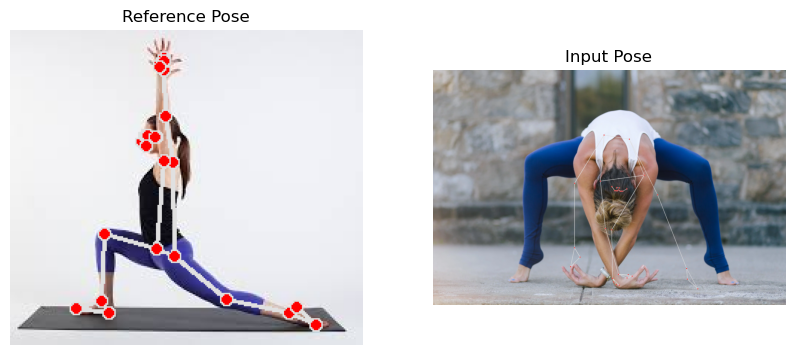


Pose similarity score: 2.2792
🔴 Poor match. Pose differs significantly.


I0000 00:00:1754117859.024576 1936192 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2


In [62]:
# === USAGE ===
# Replace with your image paths
compare_poses("arrow_lunge.jpeg", "cross.webp")

# --- Setup Pose Estimator ---
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

# --- Utility: Extract (x, y) pose landmarks from an image ---
def extract_landmarks(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb)
    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        coords = [(lm.x, lm.y) for lm in landmarks]
        return coords, result.pose_landmarks
    return None, None

# --- Utility: Calculate joint angle between 3 points ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

# --- Define joint triplets for angle comparison ---
angle_joints = {
    'left_elbow':     [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    'right_elbow':    [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    'left_shoulder':  [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP],
    'right_shoulder': [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP],
    'left_hip':       [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE],
    'right_hip':      [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE],
    'left_knee':      [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    'right_knee':     [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    'left_ankle':     [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_FOOT_INDEX],
    'right_ankle':    [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX],
    'left_wrist':     [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST, mp_pose.PoseLandmark.LEFT_INDEX],
    'right_wrist':    [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST, mp_pose.PoseLandmark.RIGHT_INDEX],
}

# --- Flip input pose if facing opposite direction from reference ---
def maybe_flip_landmarks(ref_landmarks, input_landmarks):
    def is_facing_left(landmarks):
        return landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value][0] > landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value][0]
    
    if is_facing_left(ref_landmarks) != is_facing_left(input_landmarks):
        flipped = input_landmarks.copy()
        mirror_map = {
            mp_pose.PoseLandmark.LEFT_SHOULDER.value: mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
            mp_pose.PoseLandmark.RIGHT_SHOULDER.value: mp_pose.PoseLandmark.LEFT_SHOULDER.value,
            mp_pose.PoseLandmark.LEFT_ELBOW.value: mp_pose.PoseLandmark.RIGHT_ELBOW.value,
            mp_pose.PoseLandmark.RIGHT_ELBOW.value: mp_pose.PoseLandmark.LEFT_ELBOW.value,
            mp_pose.PoseLandmark.LEFT_WRIST.value: mp_pose.PoseLandmark.RIGHT_WRIST.value,
            mp_pose.PoseLandmark.RIGHT_WRIST.value: mp_pose.PoseLandmark.LEFT_WRIST.value,
            mp_pose.PoseLandmark.LEFT_HIP.value: mp_pose.PoseLandmark.RIGHT_HIP.value,
            mp_pose.PoseLandmark.RIGHT_HIP.value: mp_pose.PoseLandmark.LEFT_HIP.value,
            mp_pose.PoseLandmark.LEFT_KNEE.value: mp_pose.PoseLandmark.RIGHT_KNEE.value,
            mp_pose.PoseLandmark.RIGHT_KNEE.value: mp_pose.PoseLandmark.LEFT_KNEE.value,
            mp_pose.PoseLandmark.LEFT_ANKLE.value: mp_pose.PoseLandmark.RIGHT_ANKLE.value,
            mp_pose.PoseLandmark.RIGHT_ANKLE.value: mp_pose.PoseLandmark.LEFT_ANKLE.value,
            mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value: mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value: mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.LEFT_INDEX.value: mp_pose.PoseLandmark.RIGHT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_INDEX.value: mp_pose.PoseLandmark.LEFT_INDEX.value,
        }
        for k, v in mirror_map.items():
            flipped[k], flipped[v] = flipped[v], flipped[k]
        return flipped
    return input_landmarks

# --- Compare angles between poses ---
def compare_angles(ref, inp):
    diffs = {}
    for joint, (p1, p2, p3) in angle_joints.items():
        a1 = calculate_angle(ref[p1.value], ref[p2.value], ref[p3.value])
        a2 = calculate_angle(inp[p1.value], inp[p2.value], inp[p3.value])
        diffs[joint] = {
            'ref_angle': round(a1, 2),
            'input_angle': round(a2, 2),
            'difference': round(abs(a1 - a2), 2)
        }
    return diffs

# --- Compute overall similarity score ---
def calculate_similarity_score(angle_diffs):
    # Lower total difference = more similar
    total_diff = sum(j['difference'] for j in angle_diffs.values())
    max_possible_diff = len(angle_diffs) * 180  # Worst case: each joint off by 180 degrees
    score = max(0, 100 - (total_diff / max_possible_diff) * 100)
    return round(score, 2)

# --- Visual feedback on user image ---
def draw_pose_feedback(image, landmarks, differences):
    h, w = image.shape[:2]
    annotated = image.copy()

    for joint, (p1, p2, p3) in angle_joints.items():
        diff = differences[joint]['difference']
        color = (0, 255, 0) if diff < 5 else (0, 255, 255) if diff < 15 else (0, 0, 255)

        pts = [landmarks[p.value] for p in [p1, p2, p3]]
        pts = [(int(x * w), int(y * h)) for x, y in pts]

        for pt in pts:
            cv2.circle(annotated, pt, 6, color, -1)
        cv2.line(annotated, pts[0], pts[1], color, 3)
        cv2.line(annotated, pts[1], pts[2], color, 3)
        cv2.putText(annotated, f"{int(diff)}°", pts[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return annotated

# --- Text feedback generator ---
def generate_feedback(angle_diffs):
    feedback = []
    for joint, data in angle_diffs.items():
        j = joint.replace('_', ' ').title()
        d = data['difference']
        if d < 5:
            feedback.append(f" {j}: Well aligned.")
        elif d < 15:
            feedback.append(f" {j}: Slight difference ({int(d)}°). Adjust slightly.")
        else:
            feedback.append(f" {j}: Off by {int(d)}°. Adjust your {j.lower()}.")
    return "\n".join(feedback)

# --- Main function for user to compare images ---
def compare_poses(ref_path, input_path):
    ref_img = cv2.imread(ref_path)
    input_img = cv2.imread(input_path)

    ref_landmarks, ref_pose = extract_landmarks(ref_img)
    input_landmarks, input_pose = extract_landmarks(input_img)

    if ref_landmarks and input_landmarks:
        # Normalize direction
        input_landmarks = maybe_flip_landmarks(ref_landmarks, input_landmarks)

        # Compare poses
        angle_diffs = compare_angles(ref_landmarks, input_landmarks)
        similarity_score = calculate_similarity_score(angle_diffs)  #  Compute similarity
        feedback_text = generate_feedback(angle_diffs)

        # Annotate input and reference
        annotated_input = draw_pose_feedback(input_img, input_landmarks, angle_diffs)
        annotated_ref = ref_img.copy()
        mp_drawing.draw_landmarks(annotated_ref, ref_pose, mp_pose.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(annotated_input, input_pose, mp_pose.POSE_CONNECTIONS)

        # Display results
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_ref, cv2.COLOR_BGR2RGB))
        plt.title("Reference Pose")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(annotated_input, cv2.COLOR_BGR2RGB))
        plt.title(f"User Pose - Similarity: {similarity_score}%")
        plt.axis('off')

        plt.suptitle("Pose Comparison Result", fontsize=18)
        plt.show()

        # Save result
        output_path = "/mnt/data/pose_feedback_result.jpg"
        cv2.imwrite(output_path, annotated_input)

        # Print feedback and score
        print(f" Pose Similarity Score: {similarity_score}%")
        print("\n Feedback:\n")
        print(feedback_text)
    else:
        print(" Pose detection failed on one or both images.")


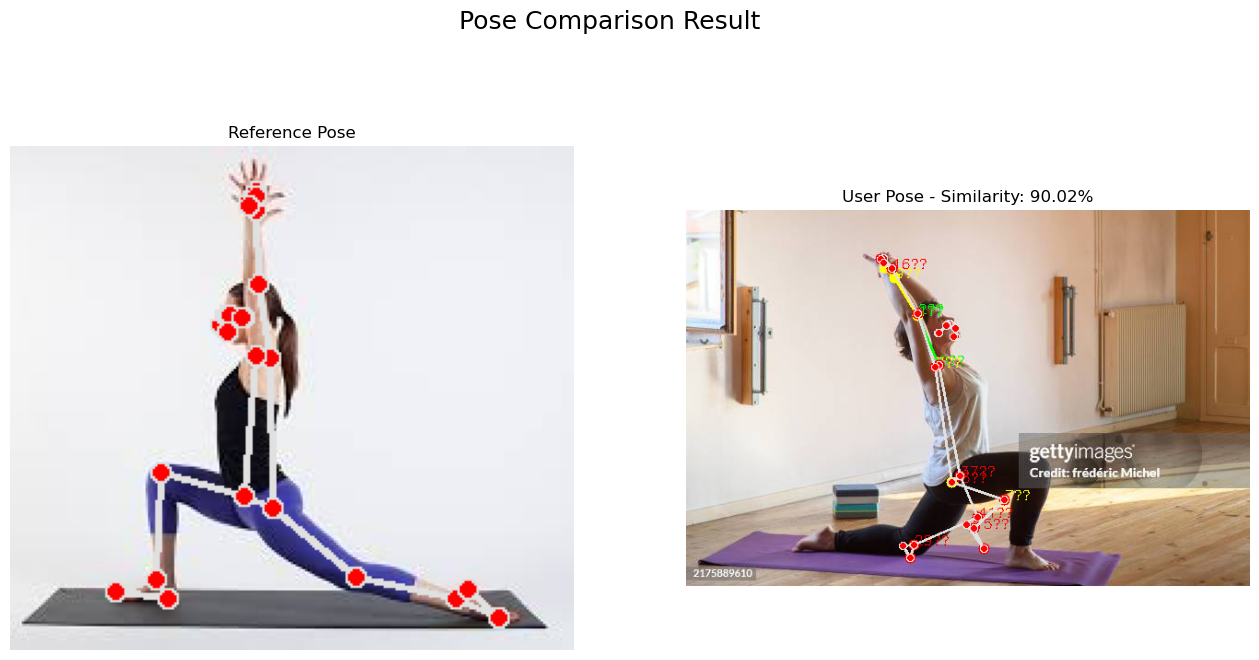

✅ Pose Similarity Score: 90.02%

📝 Feedback:

✅ Left Elbow: Well aligned.
✅ Right Elbow: Well aligned.
✅ Left Shoulder: Well aligned.
⚠️ Right Shoulder: Slight difference (7°). Adjust slightly.
❌ Left Hip: Off by 37°. Adjust your left hip.
❌ Right Hip: Off by 46°. Adjust your right hip.
❌ Left Knee: Off by 41°. Adjust your left knee.
⚠️ Right Knee: Slight difference (7°). Adjust slightly.
❌ Left Ankle: Off by 29°. Adjust your left ankle.
❌ Right Ankle: Off by 15°. Adjust your right ankle.
⚠️ Left Wrist: Slight difference (9°). Adjust slightly.
❌ Right Wrist: Off by 16°. Adjust your right wrist.


I0000 00:00:1754117972.772121 1936192 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2


In [69]:
# === USAGE ===
# Replace with your image paths
compare_poses("arrow_lunge.jpeg", "wrong_arrow_lunge.jpg")

# --- Setup Pose Estimator ---
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

# --- Utility: Extract (x, y) pose landmarks from an image ---
def extract_landmarks(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(rgb)
    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        coords = [(lm.x, lm.y) for lm in landmarks]
        return coords, result.pose_landmarks
    return None, None

# --- Utility: Calculate joint angle between 3 points ---
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

# --- Define joint triplets for angle comparison ---
angle_joints = {
    'left_elbow':     [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST],
    'right_elbow':    [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST],
    'left_shoulder':  [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP],
    'right_shoulder': [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP],
    'left_hip':       [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE],
    'right_hip':      [mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE],
    'left_knee':      [mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE],
    'right_knee':     [mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE],
    'left_ankle':     [mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_FOOT_INDEX],
    'right_ankle':    [mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX],
    'left_wrist':     [mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST, mp_pose.PoseLandmark.LEFT_INDEX],
    'right_wrist':    [mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST, mp_pose.PoseLandmark.RIGHT_INDEX],
}

# --- Flip input pose if facing opposite direction from reference ---
def maybe_flip_landmarks(ref_landmarks, input_landmarks):
    def is_facing_left(landmarks):
        return landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value][0] > landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value][0]
    
    if is_facing_left(ref_landmarks) != is_facing_left(input_landmarks):
        flipped = input_landmarks.copy()
        mirror_map = {
            mp_pose.PoseLandmark.LEFT_SHOULDER.value: mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
            mp_pose.PoseLandmark.RIGHT_SHOULDER.value: mp_pose.PoseLandmark.LEFT_SHOULDER.value,
            mp_pose.PoseLandmark.LEFT_ELBOW.value: mp_pose.PoseLandmark.RIGHT_ELBOW.value,
            mp_pose.PoseLandmark.RIGHT_ELBOW.value: mp_pose.PoseLandmark.LEFT_ELBOW.value,
            mp_pose.PoseLandmark.LEFT_WRIST.value: mp_pose.PoseLandmark.RIGHT_WRIST.value,
            mp_pose.PoseLandmark.RIGHT_WRIST.value: mp_pose.PoseLandmark.LEFT_WRIST.value,
            mp_pose.PoseLandmark.LEFT_HIP.value: mp_pose.PoseLandmark.RIGHT_HIP.value,
            mp_pose.PoseLandmark.RIGHT_HIP.value: mp_pose.PoseLandmark.LEFT_HIP.value,
            mp_pose.PoseLandmark.LEFT_KNEE.value: mp_pose.PoseLandmark.RIGHT_KNEE.value,
            mp_pose.PoseLandmark.RIGHT_KNEE.value: mp_pose.PoseLandmark.LEFT_KNEE.value,
            mp_pose.PoseLandmark.LEFT_ANKLE.value: mp_pose.PoseLandmark.RIGHT_ANKLE.value,
            mp_pose.PoseLandmark.RIGHT_ANKLE.value: mp_pose.PoseLandmark.LEFT_ANKLE.value,
            mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value: mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value: mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value,
            mp_pose.PoseLandmark.LEFT_INDEX.value: mp_pose.PoseLandmark.RIGHT_INDEX.value,
            mp_pose.PoseLandmark.RIGHT_INDEX.value: mp_pose.PoseLandmark.LEFT_INDEX.value,
        }
        for k, v in mirror_map.items():
            flipped[k], flipped[v] = flipped[v], flipped[k]
        return flipped
    return input_landmarks

# --- Compare angles between poses ---
def compare_angles(ref, inp):
    diffs = {}
    for joint, (p1, p2, p3) in angle_joints.items():
        a1 = calculate_angle(ref[p1.value], ref[p2.value], ref[p3.value])
        a2 = calculate_angle(inp[p1.value], inp[p2.value], inp[p3.value])
        diffs[joint] = {
            'ref_angle': round(a1, 2),
            'input_angle': round(a2, 2),
            'difference': round(abs(a1 - a2), 2)
        }
    return diffs

# --- Compute overall similarity score ---
def calculate_similarity_score(angle_diffs):
    # Lower total difference = more similar
    total_diff = sum(j['difference'] for j in angle_diffs.values())
    max_possible_diff = len(angle_diffs) * 180  # Worst case: each joint off by 180 degrees
    score = max(0, 100 - (total_diff / max_possible_diff) * 100)
    return round(score, 2)

# --- Visual feedback on user image ---
def draw_pose_feedback(image, landmarks, differences):
    h, w = image.shape[:2]
    annotated = image.copy()

    for joint, (p1, p2, p3) in angle_joints.items():
        diff = differences[joint]['difference']
        color = (0, 255, 0) if diff < 5 else (0, 255, 255) if diff < 15 else (0, 0, 255)

        pts = [landmarks[p.value] for p in [p1, p2, p3]]
        pts = [(int(x * w), int(y * h)) for x, y in pts]

        for pt in pts:
            cv2.circle(annotated, pt, 6, color, -1)
        cv2.line(annotated, pts[0], pts[1], color, 2)
        cv2.line(annotated, pts[1], pts[2], color, 2)
        cv2.putText(annotated, f"{int(diff)}°", pts[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return annotated

# --- Text feedback generator ---
def generate_feedback(angle_diffs):
    feedback = []
    for joint, data in angle_diffs.items():
        j = joint.replace('_', ' ').title()
        d = data['difference']
        if d < 5:
            feedback.append(f" {j}: Well aligned.")
        elif d < 15:
            feedback.append(f" {j}: Slight difference ({int(d)}°). Adjust slightly.")
        else:
            feedback.append(f" {j}: Off by {int(d)}°. Adjust your {j.lower()}.")
    return "\n".join(feedback)

# --- Main function for user to compare images ---
def compare_poses(ref_path, input_path):
    ref_img = cv2.imread(ref_path)
    input_img = cv2.imread(input_path)

    ref_landmarks, ref_pose = extract_landmarks(ref_img)
    input_landmarks, input_pose = extract_landmarks(input_img)

    if ref_landmarks and input_landmarks:
        # Normalize direction
        input_landmarks = maybe_flip_landmarks(ref_landmarks, input_landmarks)

        # Compare poses
        angle_diffs = compare_angles(ref_landmarks, input_landmarks)
        similarity_score = calculate_similarity_score(angle_diffs)  # ✅ Compute similarity
        feedback_text = generate_feedback(angle_diffs)

        # Annotate input and reference
        annotated_input = draw_pose_feedback(input_img, input_landmarks, angle_diffs)
        annotated_ref = ref_img.copy()
        mp_drawing.draw_landmarks(annotated_ref, ref_pose, mp_pose.POSE_CONNECTIONS)
        mp_drawing.draw_landmarks(annotated_input, input_pose, mp_pose.POSE_CONNECTIONS)

        # Display results
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_ref, cv2.COLOR_BGR2RGB))
        plt.title("Reference Pose")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(annotated_input, cv2.COLOR_BGR2RGB))
        plt.title(f"User Pose - Similarity: {similarity_score}%")
        plt.axis('off')

        plt.suptitle("Pose Comparison Result", fontsize=18)
        plt.show()

        # Save result
        output_path = "/mnt/data/pose_feedback_result.jpg"
        cv2.imwrite(output_path, annotated_input)

        # Print feedback and score
        print(f" Pose Similarity Score: {similarity_score}%")
        print("\n📝 Feedback:\n")
        print(feedback_text)
    else:
        print(" Pose detection failed on one or both images.")
